In [21]:
import numpy as np
from pathlib import Path
import pandas as pd
import scanpy as sc
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
cfg = readwrite.config()


def get_knn_labels(adata,label_key,knn_key,knnidx=None,n_neighbors=None,radius=None,n_jobs=-1):
    if knnidx is None:
        nn = (
            sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors,radius=radius,n_jobs=n_jobs)
            .fit(adata.obsm[knn_key])
        )
        if n_neighbors is not None and radius is not None:
            raise ValueError(
                "Please provide either n_neighbors or radius, but not both."
            )
        if n_neighbors is not None:
            knndis, knnidx = nn.kneighbors(adata.obsm[knn_key])
        elif radius is not None:
            knndis, knnidx = nn.radius_neighbors(adata.obsm[knn_key])

    df_dummies = pd.get_dummies(adata.obs[label_key])

    # Convert df_dummies to a numpy array for efficient indexing
    if not isinstance(df_dummies, np.ndarray):
        dummy_array = np.array(df_dummies)

    if knnidx.ndim == 2:
        # knnidx contains same length list of neighbor indices for each sample
        knnlabels = dummy_array[knnidx].sum(1)
    else:
        # Initialize an empty list to store the summed labels
        knnlabels = []

        # Loop over each row in knnidx
        for neighbors in knnidx:
            # Get the one-hot encoded labels for the current neighbors
            neighbor_labels = dummy_array[neighbors]

            # Sum the labels across the neighbors (axis=0 sums column-wise)
            summed_labels = neighbor_labels.sum(axis=0)

            # Append the summed labels to the list
            knnlabels.append(summed_labels)

        # Convert the list back to a numpy array (optional)
        knnlabels = np.array(knnlabels)

    knnlabels = pd.DataFrame(
        knnlabels, index=adata.obs.index, columns=df_dummies.columns
    )
    return knnlabels

## Load data

In [69]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_raw_data_dir = Path(cfg['xenium_raw_data_dir'])
results_dir = Path(cfg['results_dir'])

# Segmentation, mapping paths
dir_segmentations = {
    dir_segmentation.name: (dir_segmentation)
    for dir_segmentation in xenium_dir.iterdir()
}


# Read resegmentations and RCTD
# Coexpression params
methods = ['conditional','jaccard','pearson','spearman']

xenium_paths = {}
cc_paths = []

for segmentation in (segmentations := xenium_dir.iterdir()):
    for cohort in (cohorts := segmentation.iterdir()): 
        for panel in (panels := cohort.iterdir()):
            for sample in (samples := panel.iterdir()):
                if sample.stem != '1GA2':
                    continue
                
                for replicate in (replicates := sample.iterdir()):
                    
                    k = (segmentation.stem,cohort.stem,panel.stem,sample.stem,replicate.stem)
                    replicate_path = replicate / "normalised_results/outs"
                    name = '/'.join(k)

                    if replicate_path.exists():
                        xenium_paths[k] = replicate_path

# CC, pos_rate = read_cc_files(cc_paths, results_dir)
xenium_levels = ('segmentation','cohort','panel','sample','replicate')
ads = readwrite.read_xenium_samples(xenium_paths,anndata_only=True,transcripts=False,sample_name_as_key=False)
ads = pd.Series(ads.values(),
                index=pd.Index(ads.keys(),name = xenium_levels),
                dtype=object).sort_index()

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg_v1/NSCLC/
         chuvio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                           
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_5um/NSCLC/ch
         uvio/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5                                             
INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/proseg_v1/NSCLC/
         lung/1GA2/1GA2/normalised_results/outs/cell_feature_matrix.h5  

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is an

In [38]:
rctd_results_paths = {}
# Read RCTD
for k,path in xenium_paths.items():
    rctd_results_paths[k] = {}

    for reference in (references := path.parents[1] / "cell_type_annotation/reference_based").iterdir():
        for method in (methods := reference.iterdir()):
            for level in (levels := method.iterdir()):
                cell_type_annotation_file = level / 'single_cell/labels.csv'
                rctd_results_paths[k][reference.stem,method.stem,level.stem] = pd.read_csv(cell_type_annotation_file,index_col=0).iloc[:,0]

In [72]:
# ad = readwrite.read_xenium_sample(Path(path).stem,path,anndata_only=True,transcripts=False)[1]
ad = ads[k].copy()
max_sample_size = 10000
seed = 0

df = pd.DataFrame(rctd_results_paths[k]).dropna()
df.columns = ['_'.join(col) for col in df.columns]

ad = ad[df.index]
ad.obs = ad.obs.join(df)

sc.pp.normalize_total(ad)
sc.pp.log1p(ad)
sc.pp.pca(ad)

X = ad.obsm['X_pca']
CT_KEYS = df.columns
silhouettes = pd.Series(index=CT_KEYS)

# precompute distances on subsample
sample_size = min(max_sample_size,len(ad))
indices = np.random.default_rng(seed).permutation(X.shape[0])[:sample_size]
D = sklearn.metrics.pairwise_distances(X[indices])

for CT_KEY in CT_KEYS:
    print(CT_KEY)
    labels = ad.obs[CT_KEY].iloc[indices].values
    silhouettes.loc[CT_KEY] = sklearn.metrics.silhouette_score(
        D, labels, random_state=seed,metric='precomputed'
    )

silhouettes.to_frame().to_parquet(f"{out_dir}/silhouettes.parquet")

matched_reference_xgboost_Level4
matched_reference_xgboost_Level2
matched_reference_xgboost_Level3
matched_reference_xgboost_Level1
matched_reference_seurat_Level4
matched_reference_seurat_Level2
matched_reference_seurat_Level3
matched_reference_seurat_Level1
matched_reference_rctd_Level4
matched_reference_rctd_Level2
matched_reference_rctd_Level3
matched_reference_rctd_Level1
matched_reference_singler_Level4
matched_reference_singler_Level2
matched_reference_singler_Level3
matched_reference_singler_Level1
external_reference_xgboost_Level2
external_reference_xgboost_Level3
external_reference_xgboost_Level1
external_reference_seurat_Level2
external_reference_seurat_Level3
external_reference_seurat_Level1
external_reference_rctd_Level2
external_reference_rctd_Level3
external_reference_rctd_Level1
external_reference_singler_Level2
external_reference_singler_Level3
external_reference_singler_Level1


AttributeError: 'Series' object has no attribute 'to_parquet'

## Doublet stats plots

In [ ]:
for segmentation, dir_segmentation in dir_segmentations.items():
    ads_seg = ads[segmentation]

    for cell_type_mapping_key in CELL_TYPE_MAPPING_KEYS[:2]:
        ### spot class summary heatmap
        for ref in REFS:

            #
            df_doublet_stats = pd.DataFrame({name: ad.obs[f'spot_class_{ref}_{cell_type_mapping_key}'].value_counts(normalize=True)*100
                                                for name, ad in ads_seg.items() 
                                                if f'spot_class_{ref}_{cell_type_mapping_key}' in ad.obs})
            df_doublet_stats.index.name=f'{segmentation}_{ref}_{cell_type_mapping_key}'
            df_doublet_stats = df_doublet_stats.loc[sorted(df_doublet_stats.index)]
            # df_doublet_stats.to_csv(cfg['results_dir']+f'/annotation/rctd_doublet_stats_{ref}_{cell_type_mapping_key}_{segmentation}.csv')

            #
            plt.figure(figsize=df_doublet_stats.shape[::-1])
            sns.heatmap(df_doublet_stats,annot=True, fmt = '.1f',linewidth=1)
            plt.savefig(cfg['figures_dir']+f'xenium/annotation/rctd_doublet_stats_{ref}_{cell_type_mapping_key}_{segmentation}.png',
                        dpi=300,bbox_inches="tight")


        ### cell type pair heatmap
        # for ref in REFS:
        #     df_doublet_composition = pd.DataFrame()
        #     for name,ad in ads_seg.items():

        #         #
        #         df_ = ad.obs.query(f"spot_class_{ref}_{cell_type_mapping_key} in ['doublet_certain','doublet_uncertain','reject'] ")
        #         df_[f'both_types_{ref}_{cell_type_mapping_key}'] = df_.apply(lambda row: ' & '.join(
        #             sorted([row[f'first_type_{ref}_{cell_type_mapping_key}'], 
        #                     row[f'second_type_{ref}_{cell_type_mapping_key}']])), axis=1)

        #         df_doublet_composition[name] = df_.groupby(f'spot_class_{ref}_{cell_type_mapping_key}')[f'both_types_{ref}_{cell_type_mapping_key}'].value_counts(normalize=True)*100
        #     df_doublet_composition = df_doublet_composition.fillna(0.)

        #     for spot_class in ['doublet_certain','doublet_uncertain','reject']:

        #         df_doublet_composition_spot_class = df_doublet_composition.loc[spot_class]
        #         df_doublet_composition_spot_class = df_doublet_composition_spot_class.loc[df_doublet_composition_spot_class.sum(1).sort_values(ascending=False).index]
        #         try:
        #             fig = sns.clustermap(df_doublet_composition_spot_class, xticklabels=True, yticklabels=True,figsize=(12,len(df_doublet_composition_spot_class)//5))
        #             plt.savefig(cfg['figures_dir']+f'xenium/annotation/rctd_doublet_composition_{ref}_{spot_class}_{cell_type_mapping_key}_{segmentation}.png',
        #                         dpi=300,bbox_inches="tight")
        #             plt.close()
        #         except:
        #             print('error',ref,spot_class)
        #             continue

## Cell type composition plots

In [ ]:
CLASS_KEY_RCTD = 'first_class_FLEX_original'
CT_KEY_RCTD = 'first_type_FLEX_original'

def get_rctd_stats(ads):
    percent_class_assignments = pd.DataFrame()
    percent_cell_type_assignments = {}
    for segmentation, ads_seg in ads.items():
        for sample,ad in ads_seg.items():

            first_class = ad.obs[CLASS_KEY_RCTD].dropna()
            percent_class_assignments.loc[sample,segmentation] = first_class.sum() / len(first_class) * 100

            ct_proportions = ad.obs[CT_KEY_RCTD].dropna().value_counts('pct')
            percent_cell_type_assignments[sample,segmentation] = ct_proportions
    return percent_class_assignments, percent_cell_type_assignments

percent_class_assignments, percent_cell_type_assignments = get_rctd_stats(ads)

###### Percentage of class (rather than subtype level) assignments
sns.clustermap(percent_class_assignments)
plt.show()

###### Stacked cell type barplot
df_plot = pd.DataFrame(percent_cell_type_assignments).melt(ignore_index=False).reset_index()
df_plot.columns = [CT_KEY_RCTD,"sample","segmentation","value"]
df_plot.loc[df_plot['value'].isna(),'value'] = 0.

mode = 'all'
samples = df_plot['sample'].unique()
pivot_df = df_plot.pivot_table(index=['sample', 'segmentation'], columns=CT_KEY_RCTD, values='value', fill_value=0)

if mode == 'sample':
    for sample in pivot_df.index.unique("sample"):
        # Plot the stacked histogram
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot_df.loc[sample].plot(kind='barh', stacked=True, ax=ax, width=0.8,cmap=plt.cm.tab20,legend=None)

        # Customizing plot
        # ax.set_title('Stacked Histogram of Cell Type Composition', fontsize=14)
        ax.set_xlabel('', fontsize=12)
        ax.set_ylabel(sample, fontsize=12)
        ax.legend = None
        # ax.legend(title=CT_KEY_RCTD, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=90, ha='right')
        plt.tight_layout()
        plt.show()

elif mode == 'all':
    pivot_df_padded =  pd.concat([pd.concat([pivot_df.loc[[sample]], pd.DataFrame(0, index=[('', sample),('','')], columns=pivot_df.columns)]) for sample in pivot_df.index.unique("sample")])

    # Plot the stacked horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 15))
    cmap = ListedColormap(sns.color_palette(cc.glasbey, n_colors=len(df_plot[CT_KEY_RCTD].unique())))
    pivot_df_padded.plot(kind='barh', stacked=True, ax=ax, width=0.8, cmap=cmap)

    # Customize y-axis ticks to reflect empty space
    ax.set_yticks(range(len(pivot_df_padded)))
    ax.set_yticklabels([i[1] for i in pivot_df_padded.index], fontsize=8)
    for i,lab in enumerate(ax.get_yticklabels()):
        if lab.get_text() in samples:
            lab.set_fontweight('bold')

    # Customizing plot
    ax.set_title('Stacked Histogram of Cell Type Composition', fontsize=14)
    ax.set_xlabel('Proportion', fontsize=12)
    ax.set_ylabel('Sample and Segmentation Method', fontsize=12)
    ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Show plot
    plt.show()


## RCTD weights vs coexpression

0ZNC_0Q
92 marker genes / 340 panel genes found
0ZNC_25
92 marker genes / 340 panel genes found
16MD
92 marker genes / 340 panel genes found
11RO_run14
92 marker genes / 340 panel genes found
1GG1_02
92 marker genes / 340 panel genes found
11RO
92 marker genes / 340 panel genes found
1382
92 marker genes / 340 panel genes found
1HH8_02
92 marker genes / 340 panel genes found
1GG1_03
92 marker genes / 340 panel genes found
16M1
92 marker genes / 340 panel genes found
16MD_run14
92 marker genes / 340 panel genes found
1HH8_0J
92 marker genes / 340 panel genes found
16MO
92 marker genes / 340 panel genes found
16M1_run14
92 marker genes / 340 panel genes found
137O
92 marker genes / 340 panel genes found
13PE
92 marker genes / 340 panel genes found
0ZNC_25
92 marker genes / 340 panel genes found
16MD
92 marker genes / 340 panel genes found
0ZNC_0Q
92 marker genes / 340 panel genes found
11RO
92 marker genes / 340 panel genes found
1GG1_02
92 marker genes / 340 panel genes found
11RO_run14

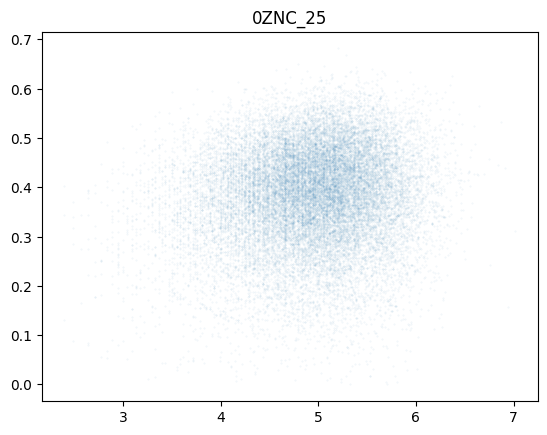

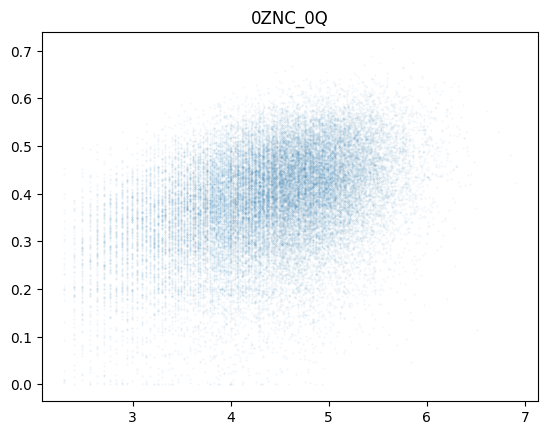

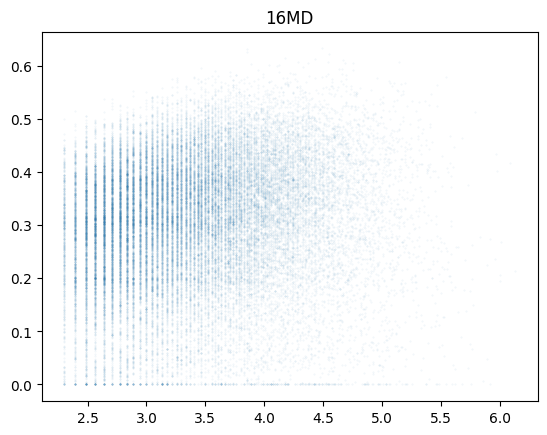

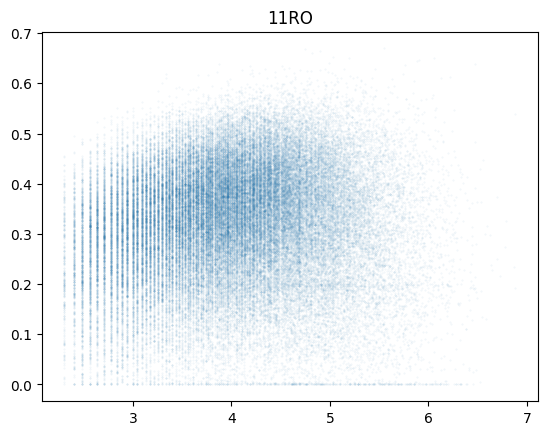

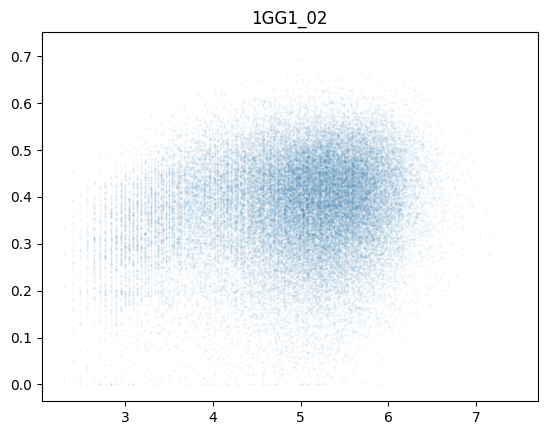

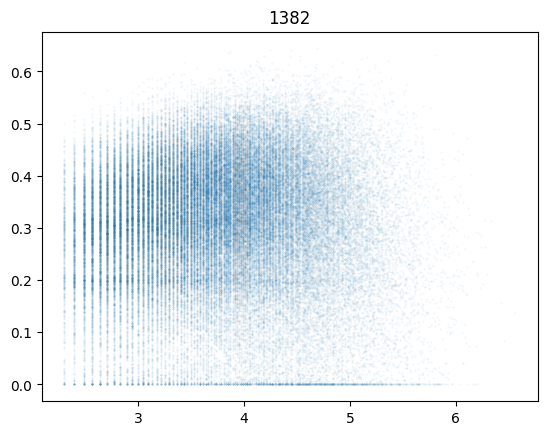

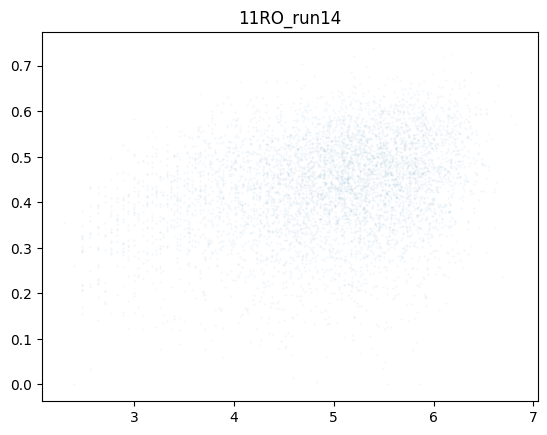

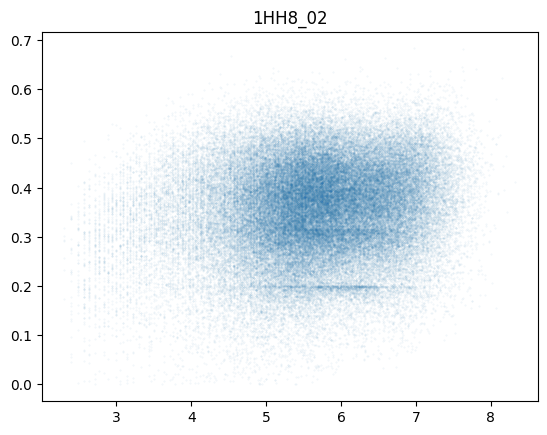

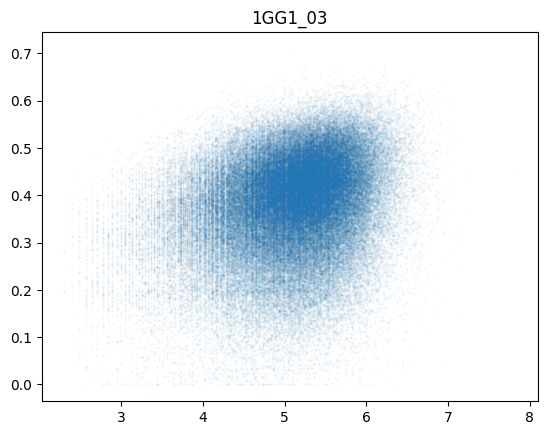

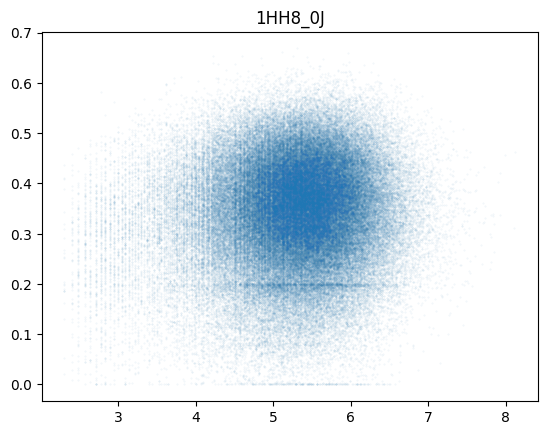

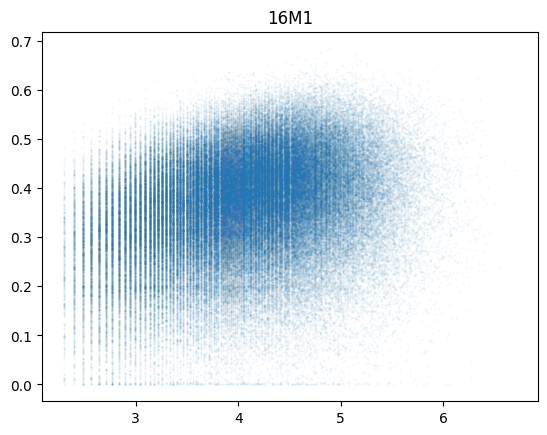

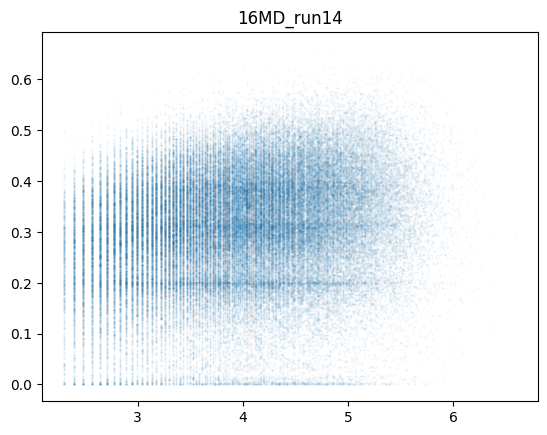

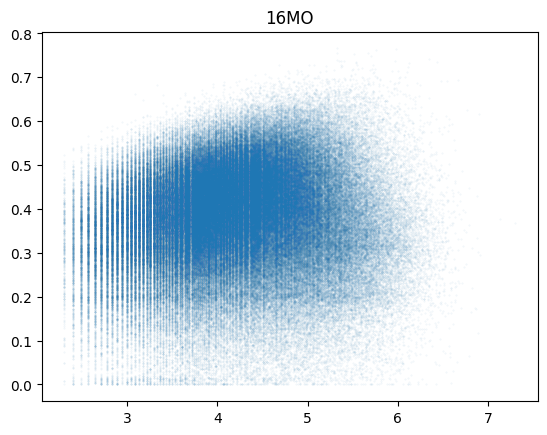

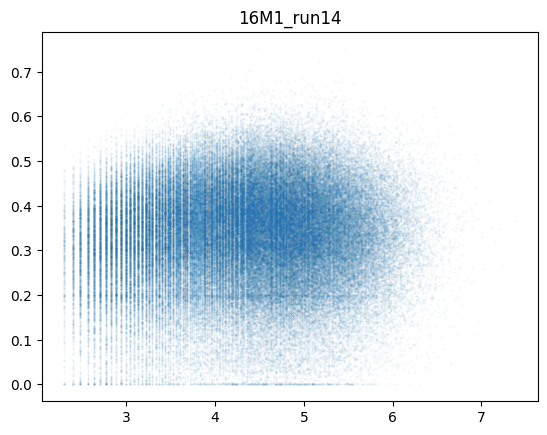

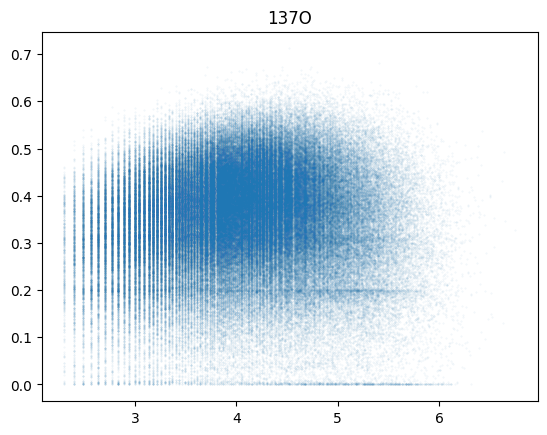

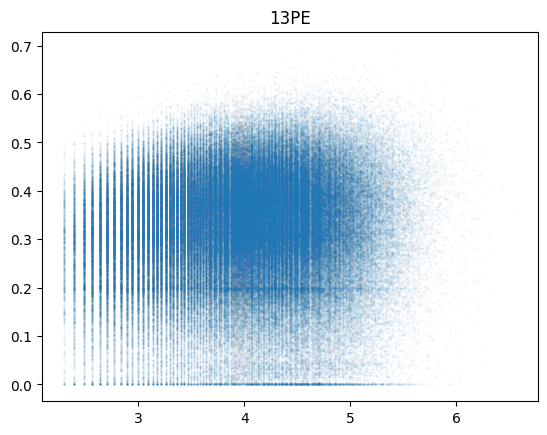

In [4]:
df_markers = pd.read_json(cfg['data_dir']+'markers/hubmap_cell_types_markers_DB.json').explode('canonical').reset_index().drop_duplicates()
rctd_weights_key = 'weights_FLEX_original'

normalized_entropy = {}
CC_cells_sum_normalized = {}

for segmentation in SEGMENTATIONS:

    normalized_entropy[segmentation] = {}
    CC_cells_sum_normalized[segmentation] = {}

    for k,ad_ in ads[segmentation].items():
        print(k)

        ad = ad_[ad_.uns[rctd_weights_key].index]

        ### Entropy
        W = ad.uns[rctd_weights_key].copy()
        W[W<0] = 0.
        W = sklearn.preprocessing.normalize(W,axis=0,norm='l1')
        normalized_entropy[segmentation][k] = scipy.stats.entropy(W,axis=1)/np.log(W.shape[1])

        ### Coexpression
        # load markers
        df_markers_panel = df_markers[df_markers['canonical'].isin(ad.var_names)]
        u_markers_panel = df_markers_panel['canonical'].unique()
        marker_genes_idx = ad.var_names.isin(u_markers_panel)
        print(len(u_markers_panel), 'marker genes /', ad.shape[1],'panel genes found')

        # compute CC
        # CCnuc, Xnuc_downsampled, pos_nuc, pos_rate_nuc, mask_nuc = coexpression.coexpression(ad,target_count=None)
        # df_ct_markers_cc = coexpression.coexpression_by_cell_type(CCnuc,u_markers_panel,df_markers_panel)
        # CC_cells = coexpression.coexpression_cells(pos_nuc)
        # CC_cells_sum = coexpression.coexpression_cells_score(CC_cells, marker_genes_idx)
        # CC_cells_sum_normalized[segmentation][k] = np.array(CC_cells_sum)/(marker_genes_idx.sum()**2)


# palette = {'singlet':'green','doublet_certain':'blue','doublet_uncertain':'orange','reject':'red'}
# for segmentation in SEGMENTATIONS[:1]:
#     for k,ad_ in ads[segmentation].items():
#         ad = ad_[ad_.uns[rctd_weights_key].index]

#         g = sns.jointplot(x=normalized_entropy[k], y=CC_cells_sum_normalized[k], palette=palette,hue=ad.obs['spot_class_FLEX_NULL'],kind="scatter", height=5,s=8,alpha=.3)
#         g.set_axis_labels(f'{k} - normalized RCTD weights normalized entropy', f'{k} - normalized coexpression score')
#         plt.show()

# for sample,ad in ads[segmentation].items():
#     ad_ = ad[ad.uns[rctd_weights_key].index]
#     plt.title(sample)
#     plt.scatter(np.log(ad_.obs['total_counts']),normalized_entropy[segmentation][sample],s=.1,alpha=.1)
#     plt.show()

In [69]:
ad_doublets.obs[CT_KEY_RCTD_SECOND_TYPE].replace(labels_to_num).unique()

array(['11', '8', '6', '12', '15', '5', '4', '17', '28', '20', '30', '19',
       '27', '0', '21', '13', '7', '3', '1', '2', '18', '25', '22', '26',
       '23', '9', '24', '16', '14', '10', 'epithelial cell of lung'],
      dtype=object)

In [66]:
SPOT_CLASS_KEY_RCTD = 'spot_class_FLEX_original'
CLASS_KEY_RCTD = 'first_class_FLEX_original'
CT_KEY_RCTD = 'first_type_FLEX_original'
CT_KEY_RCTD_SECOND_TYPE = 'second_type_FLEX_original'

ad = ad_[ad_.uns[rctd_weights_key].index]
idx_doublets = ad.obs[SPOT_CLASS_KEY_RCTD].isin(['doublet_certain', 'doublet_uncertain'])
ad_doublets = ad[idx_doublets]
normalized_entropy_doublets = normalized_entropy[segmentation][sample]


labels = get_knn_labels(ad_doublets,label_key=CT_KEY_RCTD,knn_key='spatial',radius=10)
labels_to_num = dict(zip(labels.columns,np.arange(labels.shape[1]).astype(str)))
second_types_numeric = ad_doublets.obs[CT_KEY_RCTD_SECOND_TYPE].replace(labels_to_num).astype(int)
second_types_count_in_knn = labels.values[range(len(ad_doublets)),second_types_numeric]

plt.scatter(second_types_count_in_knn,normalized_entropy_doublets,s=.1,alpha=.1)

ValueError: invalid literal for int() with base 10: 'epithelial cell of lung'

## RCTD weights vs coexpression based on computational marker genes

### Estimate genes coexpression from scRNA

In [ ]:
# load doublets
result = pyreadr.read_r('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/dbuszta/meso/processed_data/new_data/doublets_by_sample.rds')[None]

# load data
ad_sc = sc.read_h5ad(cfg['scrnaseq_processed_flex_full_zurich_h5ad'])
ad_sc.obs['doublet_status'] = result.iloc[:,0]
ad_sc = ad_sc[ad_sc.obs['doublet_status']=='singlet']
ad_sc.obs = ad_sc.obs.join(pd.read_csv(cfg['results_dir']+'annotation/cell_type_annotation.csv',index_col=0))

# filter to xenium genes
xenium_panel_genes = pd.read_csv(cfg['data_dir']+'xenium_chuvio_panel_genes.csv',index_col=0)['0']
ad_sc_panel = ad_sc[:,ad_sc.var_names.isin(xenium_panel_genes)]

CT_KEY = 'cell_type_harmonized_level2_consensus'
u_cell_types = ad_sc_panel.obs[CT_KEY].unique()

# get df with max fraction for each cell type
(df_fraction,df_difference, 
df_max_difference) = coexpression.find_markers(ad_sc_panel, CT_KEY, threshold_fraction = 1., threshold_diff = 0.)
df_difference_sorted = df_difference[df_difference.max().sort_values().index]

# get df with thresholded max fraction for each cell type
(_,df_difference_thresholded, 
 df_max_difference_thresholded) = coexpression.find_markers(ad_sc_panel, CT_KEY, threshold_fraction = 0.01, threshold_diff = 0.25)
df_difference_thresholded_sorted = df_difference_thresholded[df_difference_thresholded.max().sort_values().index]

for df_difference_sorted_, df_max_difference_ in zip([df_difference_sorted,df_difference_thresholded_sorted],
                                                     [df_max_difference,df_max_difference_thresholded]):

    ### Boxplots
    plt.figure(figsize=(8,30))

    flierprops = dict(marker='o', markersize=1, linestyle='none', markerfacecolor='black')
    ax = sns.boxplot(data=df_difference_sorted_, orient='h', flierprops=flierprops)

    # Loop over columns to find and highlight max fliers
    for i, col in enumerate(df_difference_sorted_.columns):
        data = df_difference_sorted_[col]
        max_val = data.max()  # Find maximum value in the column
        ax.scatter(max_val,i, color='red', edgecolor='black', zorder=5, s=20)

    plt.title("Difference in % of cells expressing")
    plt.show()

    ### Heatmap
    sns.heatmap(df_max_difference_)

# Define markers
df_markers_scores = pd.DataFrame(index=ad_sc_panel.var_names,columns=u_cell_types)

for cti in u_cell_types:
    cti_columns = df_difference_thresholded.columns.str.split("_").str[0] == cti

    df_markers_scores[cti] = df_difference_thresholded.loc[:,cti_columns].mean(1)

ct_markers = {}
for ct in u_cell_types:
    ct_scores = df_markers_scores[ct].sort_values(ascending=False).dropna()
    markers_ = list(ct_scores[(ct_scores>0.)][:10].index)

    if len(markers_) > 0:
        ct_markers[ct] = markers_

df_markers_computational = pd.DataFrame([
    {"index": k, "canonical": v}
    for k, values in ct_markers.items()
    for v in values
])

### Coexpression

In [ ]:
rctd_weights_key = 'weights_FLEX_original'

normalized_entropy_computational = {}
CC_computational = {}
CC_cells_sum_normalized_computational = {}

for segmentation in SEGMENTATIONS:

    normalized_entropy_computational[segmentation] = {}
    CC_computational[segmentation] = {}
    CC_cells_sum_normalized_computational[segmentation] = {}
        
    for k,ad_ in ads[segmentation].items():
        print(k)

        ad = ad_[ad_.uns[rctd_weights_key].index]

        ### Entropy
        W = ad.uns[rctd_weights_key].copy()
        W[W<0] = 0.
        W = sklearn.preprocessing.normalize(W,axis=0,norm='l1')
        normalized_entropy_computational[segmentation][k] = scipy.stats.entropy(W,axis=1)/np.log(W.shape[1])

        ### Coexpression
        # compute CC
        CC, X_downsampled, pos, pos_rate, mask = coexpression.coexpression(ad,target_count=30,method='jaccard')
        CC_computational[segmentation][k] = CC

        # load markers
        # df_markers_computational_panel = df_markers_computational[df_markers_computational['canonical'].isin(ad.var_names)]
        # u_markers_panel = df_markers_computational_panel['canonical'].unique()
        # marker_genes_idx = ad.var_names.isin(u_markers_panel)
        # print(len(u_markers_panel), 'marker genes /', ad.shape[1],'panel genes found')

        # df_ct_markers_cc = coexpression.coexpression_by_cell_type(CC,u_markers_panel,df_markers_computational_panel)
#         CC_cells = coexpression.coexpression_cells(pos)
#         CC_cells_sum = coexpression.coexpression_cells_score(CC_cells, marker_genes_idx)
#         CC_cells_sum_normalized_computational[k] = np.array(CC_cells_sum)/(marker_genes_idx.sum()**2)
#         break

# palette = {'singlet':'green','doublet_certain':'blue','doublet_uncertain':'orange','reject':'red'}
# for segmentation in SEGMENTATIONS[:1]:
#     for k,ad_ in ads[segmentation].items():
#         ad = ad_[ad_.uns[rctd_weights_key].index]

#         g = sns.jointplot(x=normalized_entropy_computational[k], y=CC_cells_sum_normalized_computational[k], palette=palette,hue=ad.obs['spot_class_FLEX_original'],kind="scatter", height=5,s=8,alpha=.3)
#         g.set_axis_labels(f'{k} - normalized RCTD weights normalized entropy', f'{k} - normalized coexpression score')
#         plt.show()
#         break

In [ ]:
rctd_weights_key = 'weights_FLEX_original'

# Define a function for processing one (segmentation, k) pair
def process_task(segmentation, k, ad_, rctd_weights_key):
    print(f"Processing {segmentation}, {k}")

    # Filter data
    ad = ad_[ad_.uns[rctd_weights_key].index]

    # Entropy computation
    W = ad.uns[rctd_weights_key].copy()
    W[W < 0] = 0.0
    W = sklearn.preprocessing.normalize(W, axis=0, norm='l1')
    normalized_entropy = scipy.stats.entropy(W, axis=1) / np.log(W.shape[1])

    # Coexpression computation
    CC, X_downsampled, pos, pos_rate, mask = coexpression.coexpression(ad, target_count=30, method='jaccard')

    return segmentation, k, normalized_entropy, CC

# Prepare the tasks
tasks = []
for segmentation in SEGMENTATIONS:
    for k, ad_ in ads[segmentation].items():
        tasks.append((segmentation, k, ad_, rctd_weights_key))

# Run tasks in parallel
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_task)(segmentation, k, ad_, rctd_weights_key) for segmentation, k, ad_, rctd_weights_key in tasks
)

# Collect results
normalized_entropy_computational = {seg: {} for seg in SEGMENTATIONS}
CC_computational = {seg: {} for seg in SEGMENTATIONS}

for segmentation, k, entropy, CC in results:
    normalized_entropy_computational[segmentation][k] = entropy
    CC_computational[segmentation][k] = CC


In [ ]:
sample = '16MD_run14'
coexpr_scores = pd.DataFrame()
normalized_entropy_computational_scores = pd.DataFrame()
for segmentation,CC_segmentations in CC_computational.items():
    for sample, CC_sample in CC_segmentations.items():
        coexpr_scores.loc[segmentation,sample] = CC_sample.values[np.triu_indices_from(CC_sample,1)].sum()
        normalized_entropy_computational_scores.loc[segmentation,sample] = normalized_entropy_computational[segmentation][sample].sum()

sns.clustermap(coexpr_scores.fillna(coexpr_scores.mean()),figsize=(10,5),cmap='Reds')

coexpr_scores_norm = coexpr_scores.fillna(coexpr_scores.mean())
sns.clustermap(coexpr_scores_norm/coexpr_scores_norm.max(),figsize=(10,5),cmap='Reds')

sns.clustermap(normalized_entropy_computational_scores,figsize=(10,5),cmap='Reds')
sns.clustermap(normalized_entropy_computational_scores/normalized_entropy_computational_scores.max(),figsize=(10,5),cmap='Reds')

In [ ]:
median_transcripts_per_cell = pd.DataFrame()
for segmentation, ads_seg in ads.items():
    for sample, ad in ads_seg.items():
        median_transcripts_per_cell.loc[segmentation,sample] = ad.uns['metrics_summary'].loc[0,'median_transcripts_per_cell']

In [ ]:
df1 = normalized_entropy_computational_scores
df2 = coexpr_scores

plot_data = []
for idx in df1.index:
    for col in df1.columns:
        plot_data.append({
            'segmentation': idx,
            'samples': col,
            'normalized_entropy_computational_scores': df1.loc[idx, col],
            'coexpr_scores': df2.loc[idx, col]
        })

plot_df = pd.DataFrame(plot_data)

sns.boxplot(plot_df,x='segmentation',y='coexpr_scores');plt.show()
sns.boxplot(plot_df,x='segmentation',y='normalized_entropy_computational_scores')

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='normalized_entropy_computational_scores',  # x-axis: values from df1
    y='coexpr_scores',  # y-axis: values from df2
    hue='segmentation',  # color based on segmentation
    style='samples',  # marker type based on samples
    s=50  # marker size
)

# plt.title('Scatter Plot: df1 vs df2')
# plt.xlabel('Values from df1')
# plt.ylabel('Values from df2')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
# Find universal markers
ad_sc_panel.var['n_cells'] = (ad_sc_panel.X>0).sum(0).A1
ad_sc_panel.var['n_cells'].hist(bins=100)
CC, X_downsampled, pos_, pos_rate_, mask_ = coexpression.coexpression(ad_sc_panel,target_count=None,min_cond_coex=0.)

threshold = 0.01
pos_rate_threshold = 0.01

valid_genes = np.where(pos_rate > pos_rate_threshold)[0]

gene_pairs_idx = np.vstack((CC.values<threshold).nonzero()).T
gene_pairs_idx_u = pd.DataFrame(gene_pairs_idx)
gene_pairs_idx_u['Key'] = gene_pairs_idx_u.apply(lambda row: tuple(sorted(row)), axis=1)
gene_pairs_idx_u = gene_pairs_idx_u.drop_duplicates(subset='Key').drop(columns='Key')
gene_pairs_idx_u = gene_pairs_idx_u[gene_pairs_idx_u.isin(valid_genes).sum(1)==2]
gene_pairs_idx_u = gene_pairs_idx_u.values
print(len(gene_pairs_idx_u))

# Score xenium samples per gene
# CC_computational_scores = {}
# for segmentation in SEGMENTATIONS:
#     for k,ad_ in ads[segmentation].items():
#         CC_computational_scores[segmentation][k] = CC_computational[segmentation][k].values[gene_pairs_idx_u[:,0],gene_pairs_idx_u[:,1]].sum(1)

# Score xenium samples per cell
# CC_cells_score = coexpression.coexpression_cells_score_gene_pairs(CC_cells, gene_pairs_idx_u)

# ad.obs['CC_cells_score'] = CC_cells_score
# ad.obs['CC_cells_score'].hist(bins=100)

# sc.set_figure_params(figsize=(10,10))
# sc.pl.spatial(ad,color='CC_cells_score',spot_size=10,)
# (ad.obs['CC_cells_score']>0).sum()

In [ ]:
sc.pl.spatial(ad,color='CC_cells_score',spot_size=20,vmax=1)

## Spurious genes to do

In [ ]:
## Find universal markers from scRNAseq

## Find markers by cell type pair from scRNAseq

## Find spurious genes 0um vs 15um

## Group spurious genes by cell type pair

## Assess spurious genes coexpression in other segmentations